# 네이버 영화리뷰 감정 분석 문제에 SentencePiece 적용해 보기

네이버 영화리뷰 감정 분석 태스크가 있습니다. 한국어로 된 corpus를 다루어야 하므로 주로 KoNLPy에서 제공하는 형태소 분석기를 사용하여 텍스트를 전처리해서 RNN 모델을 분류기로 사용하게 되는데요.

만약 이 문제에서 tokenizer를 SentencePiece로 바꾸어 다시 풀어본다면 더 성능이 좋아질까요? KoNLPy에 있는 Mecab, kkma, Okt 등과 비교해보세요. (여러분들은 fasttext로 사전훈련된 Word Vector를 사용할 수 있지만 sentencepiece와 KoNLPy에 있는 형태소로 모델을 만드는 것보다 코드 수정이 많이 일어납니다. 기본적인 태스크를 끝나고(sentencepiece - KoNLPy 형태소 비교) 도전하시는걸 추천합니다.)

## 프로젝트: SentencePiece 사용하기

In [12]:
import tensorflow as tf
import numpy as np
import matplotlib as plt
import konlpy

print(tf.__version__)
print(np.__version__)
print(plt.__version__)
print(konlpy.__version__)

2.6.0
1.21.4
3.4.3
0.5.2


In [13]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

from collections import Counter
from sklearn.model_selection import train_test_split

from konlpy.tag import Hannanum,Kkma,Komoran,Mecab,Okt

In [14]:
from tqdm import tqdm, trange

tqdm.pandas()

In [15]:
import os, re

## 데이터 불러오기

In [16]:
train_path = './data/ratings_train.txt'
test_path = './data/ratings_test.txt'


train = pd.read_table(train_path)
test = pd.read_table(test_path)

In [17]:
train.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [18]:
test.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [19]:
print(f"train shape => {train.shape} \ntest shape => {test.shape}")

train shape => (150000, 3) 
test shape => (50000, 3)


In [20]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

## 훈련 데이터 라벨링 값 비율 확인

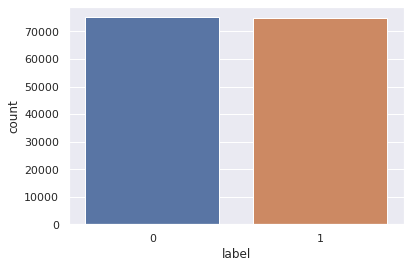

In [21]:
sns.set_theme(style="darkgrid")
ax = sns.countplot(x="label", data=train)

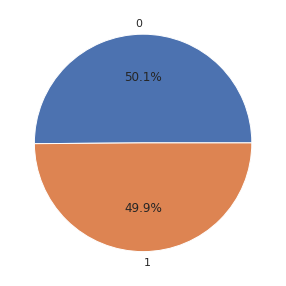

In [22]:
labels, frequencies = np.unique(train.label.values, return_counts=True)
plt.figure(figsize=(5,5))
plt.pie(frequencies, labels = labels, autopct= '%1.1f%%')
plt.show()

## 훈련, 테스트 데이터 결측치 값 확인

In [23]:
train.isnull().sum()

id          0
document    5
label       0
dtype: int64

In [24]:
test.isnull().sum()

id          0
document    3
label       0
dtype: int64

In [25]:
train.drop_duplicates(subset=['document'], inplace=True)
test.drop_duplicates(subset=['document'], inplace=True)
train.dropna(inplace=True)
test.dropna(inplace=True)

# 전처리
## 1) train, test data의 문장 길이 확인

In [26]:
train_len = train.document.apply(lambda x: len(x))

In [27]:
train_len.describe()

count    146182.000000
mean         35.981338
std          29.491233
min           1.000000
25%          16.000000
50%          27.000000
75%          43.000000
max         146.000000
Name: document, dtype: float64

<AxesSubplot:>

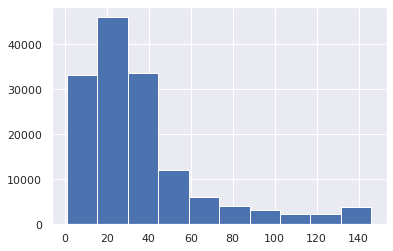

In [28]:
train_len.hist()

<AxesSubplot:>

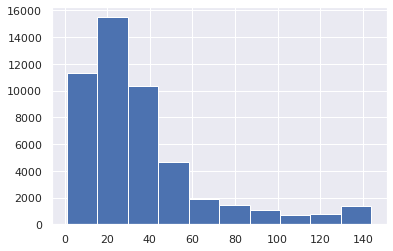

In [29]:
test.document.apply(lambda x: len(x)).hist()

- train len과 test len의 분포를 비교해본 결과 상당히 유사해서 길이를 줄이는 등의 전처리는 진행하지 않는 것이 좋을 것 같았다

## 2) 길이가 너무 길거나 짧은 실제 데이터 확인 

- 한글자의 경우도 의미가 없지 않을 까 확인해봤는데 굿, 욜 이런 부분에서 의미가 있는 부분도 있었다
- 문자를 다 삭제하는 것도 고민해봐야겠다. ♥,♡,乃, ㅄ 도 의미가 있어보인다

In [30]:
train.loc[train_len[train_len > 145].index].document

40628     "스폰으로 먹고사는 방송이라 어쩔수 없다고 하지만. 이건 그냥 비현실적인 자동차만;...
80320     """니 짓은 생각않고, 웬 복수!""의 교훈이라! 그럼 ""서바이벌 액션""으로 ...
124252    "2007.02.25_ 벌교의 한 국밥집_ 점심: ""갸는 첫째고, 저 놈은 우리 ...
Name: document, dtype: object

In [31]:
' '.join(train.loc[train_len[train_len == 1].index].document)

'아 잼 1 4 굿 짱 휴 . 음 ? ㅎ ㅋ 즐 ♥ 굳 네 ㅇ k ㅠ 쒯 ♬ 토 O 똥 z 헐 삼 꽝 ! 풉 ㅅ 왜 ㄴ 쉣 봐 뿌 ㅜ ♡ ㅁ 0 ㅉ d 흥 乃 찜 귯 린 시 ㅗ a c 흠 웅 ㅣ 오 9 쩜 애 헝 쨩 f 움 ㄳ 업 헉 군 b ; g 올 걍 허 - 쀍 로 ㄹ ㅂ 갑 즛 킥 함 진 ㅡ 잠 곧 ㅍ h · 캬 ㅆ , 풋 ㄱ 파 ㄷ 웩 꺅 욜 ㅄ 2 핡'

- 한글자의 경우도 의미가 없지 않을 까 확인해봤는데 굿, 욜 이런 부분에서 의미가 있는 부분도 있었다
- 문자를 다 삭제하는 것도 고민해봐야겠다. ♥,♡,乃, ㅄ 도 의미가 있어보인다

In [32]:
import re

### 반복되는 문자 처리 추가

In [33]:
i = '숨은글씨 찾기 의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리니의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리의리'

re.sub('(\\S{2})\\1+', '\\1', i)

'숨은글씨 찾기 의리니의리'

In [34]:
len(train)

146182

In [ ]:
### 최종 전처리 함수
- 한글, 숫자, 초성, ♥♡乃ㄳㅄ의 문자를 남겼다
- 초성 ㅜㅜ, ㅋㅋ이 감정의 의미를 담을 수 있다고 파악했기 때문이다
- 다중 공백을 제거하는 코드를 추가하였다
- ㅋ와 ㅋㅋ은 다르게 인지하였다
    - ㅜㅜㅜ, ㅋㅋㅋㅋㅋㅋ 등의 다중 초성은 2개의 초성으로 모두 합쳐주었다
- 빈 하트와 채워진 하트는 채워진 하트로 통일하고 하트의 갯수는 모두 하나로 바꿔주었다
- 반복되는 문자열은 하나만 남기고 지워줬다

In [36]:
def preprocessing(train, col='document'):
    train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
    train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경
    train[col].replace('', np.nan, inplace=True) # 공백은 Null 값으로 변경
    train.dropna(how='any', inplace=True)
    
    train[col] = train[col].apply(lambda x: ' '.join(x.split()))
    train[col] = train[col].apply(lambda x: re.sub(r'(ㅋ|ㅎ|ㅜ|ㅠ){2,}', lambda m: m.group(1) * 2, x)) # 반복되는 2자리 문자 처리

    train[col] = train[col].str.replace(r'♡','♥')
    train[col] = train[col].apply(lambda x: re.sub(r'♥+', '♥', x))
    train[col] = train[col].apply(lambda x: re.sub(r'\b(\S+)( \1)+', r'\1', x))
    
    return train

In [37]:
train = preprocessing(train, col='document')

/tmp/ipykernel_2247/3900349715.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
/tmp/ipykernel_2247/3900349715.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [38]:
train.document[train.document.str.contains('♥|♡')].tolist()[:10]

['걍인피니트가짱이다진짜짱이다♥',
 '이건 정말 깨알 캐스팅과 질퍽하지않은 산뜻한 내용구성이 잘 버무러진 깨알일드♥',
 '넘 사랑스러운 영화다 ㅠㅠ 1보고 2 연이어 봤다 넘 귀여워 ㅠㅠ♥',
 '1996년 그때 당시에는 우리 나라에 이런 판타지 로맨스가 없었다 아직도 신현준의 황장군 연기는 음 괜찮네 ㅎㅎ한석규의 전성시대가 열린 영화 이때 한석규한테 뿅 갔었다♥',
 '정은지 언니 연기 잘하구노래도 잘부르시고 마지막회 웃으면서 즐겁게 봤습니다 트로트의 연인♥',
 '니노의 이중인격연기 두근거리네요♥',
 '극장가서 안본 내머리를 깨버리고싶네요 제인생 최고의 영홥니다 키이라작품 중에서도 최고일듯 알럽키이라♥',
 '내사랑 키아누 ♥ 리브스 ♥',
 '김윤진 좋아하니깐♥',
 '너무재밋당최지우연기잘한다♥',
 '정말짱이에요진짜감동받을만큼눈물나게잘쓰셨네요별점십점드릴게요♥',
 '짱짱♥',
 '윤하♥ 때문에 10점',
 '♥',
 '아나 진짜이거짱져아요즘시험기간인데도 봄♥내가원래지빈오빠팬이라서 보다가 계속보는데 졸잼중간중간에 울다웃고 겁나 감동적이고 혜결이가복녀님따라하는거 기여엉 복녀님이 누군지알고싶소끝까니 닥본할끙♥',
 '진짜 재미있다 대박역시 신하균♥',
 '내 나이 14살에 이런 멋진 동시같은 영화는 처음이다 장르를 건너뛰고 대한민국 최고 영화라고 난 생각한다 하늘이 두쪽나는 일이 있어도 훈훈하고 슬프고 아름다운 공포물은 다시 나오지 못할것이다♥',
 '아 진짜 재밌게 봤습니다♥',
 '아완죤반했엇♥ 주인공인 팡지엔인가완죤 멋져♥',
 '주원오빠랑 기웅오빠 보고 완전히 빠졌어요♥ 다들 정말 촬영 수고 많으셨어요 항상 배우님들 응원합니다 파이팅',
 '많은 것에 대해 배웠다 캐리와 빅이 행복하길♥',
 '박스오피스1위 할만하네요초반 이야기시작 에피소드에서 웃음을찾고 중반부터 끝으로 갈수록 흥미진진한내용에 시간가는줄 몰랐습니다 10점이아닌이유는너무 재밌어서 나만보려고♥찡끗',
 '완전 재미있음 추천 ㅠㅠ♥ 생텀 화이팅 ♥',
 '에수님ㅠㅠ♥우아아아아유ㅜㅜ',

<AxesSubplot:>

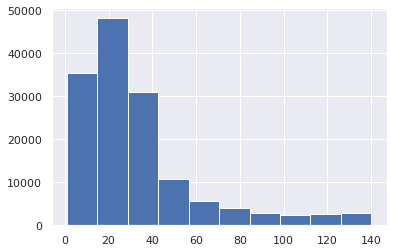

In [39]:
train.document.apply(lambda x: len(x)).hist()

In [40]:
train.document.apply(lambda x: len(x)).describe()

count    145510.000000
mean         33.154202
std          28.073335
min           1.000000
25%          15.000000
50%          25.000000
75%          40.000000
max         140.000000
Name: document, dtype: float64

In [41]:
train_len = train.document.apply(lambda x: len(x))

train.loc[train_len[train_len > 135].index].document.tolist()[:10]

['아 진짜 조금만 더 손 좀 보면 왠만한 상업 영화 못지 않게 퀄리티 쩔게 만들어 질 수 있었는데 아쉽네요 그래도 충분히 재미있었습니다 개인적으로 조금만 더 잔인하게 더 자극적으로 노출씬도 화끈하게 했더라면 어땠을까 하는 국산영화라 많이 아낀 듯 보임',
 '화려한 색채때문에 눈이 아프지만 그 나름대로 화려연예계여자욕망에대해 표현해냈던거같다 보는내내 진짜 리리코심정가진 연옌들도 있을거같고나를한번도보지못하고알지못하는사람들이날어떻게사랑하냐그런대사 나왔을때 소름돋더라 연예인들은 많은사랑받으면서도 참 허전할듯',
 '한편의 영화에 너무도 많은걸 하려구 한거 같은데 결국 이것도 저것도 아닌 영화가 되버렸다 뭔가 한가지 뛰어난게 없다 겜블영화도 아니고 갱영화도 아니구 형사물도 아니구 그냥 킬링타임용으로도 솔직히 별루다 밴에플렉 펜이지만 좋은 점수를 줄수가 없다',
 '쥬산과 데이는 샬로를 너무도 순수하고맹목적으로 사랑했지만 정작 샬로는 그들이 자신을 사랑하는만큼 그들을 사랑하지 않았고 자기 본능과 자기 살길에 더 충실했던 답답한 인간일 뿐이었다덕분에 쥬산과 데이의 최후는 너무도 가슴을 아리고 먹먹하게 만든다',
 '우선 평점 1점의 이유는 현재 평점이 너무나 높기때문이다 간략해서 영화보는 내내 엄청나게 불편햇다 서울시장 후보아내 엄정화가 나와서 서른도넘은 섹시가수 몸에착달라붙고 가슴이거의다 보이는 의상을입고 춤을출때 불쾌함을넘어 상당히 안좋은기분을 느끼게해준다',
 '초등학생 시절에 접했던 스파이더맨 3부작을 히어로물 매니아가 된 지금 다시 찾았다 리부트 후 세계관 확장에 신경쓰고 있지만 독립된 세계관으로써도 깊은 여운과 재미를 줬던 샘레이미 감독과 토비 맥과이어의 스파이더맨 3부작은 정말 최고라 말하고 싶다',
 '예회장의 매력이 걷잡을수 없다 무간도 시리즈의 다른 작품들과 등장인물이 거의 완전히 다름에도 불구하고 다른 무간도 시리즈와 잘 조화되며 이 작품만이 주는 매력 또한 상당하다 한침의 먹방이 정말 압권 예회장의 카리스마는 대부의 돈 꼴레오네를 연상',
 '너무

In [42]:
corpus = train.document.tolist()

### 네이버 영화리뷰 감정 분석 코퍼스에 SentencePiece를 적용시킨 모델 학습하기

In [32]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp --model_prefix=korean_spm --vocab_size=8000
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 8000
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_id

In [33]:
#위 Train에서  --model_type = unigram이 디폴트 적용되어 있습니다. --model_type = bpe로 옵션을 주어 변경할 수 있습니다.

!ls -l korean_spm*

-rw-r--r-- 1 root root 377035 Jul  1 02:27 korean_spm.model
-rw-r--r-- 1 root root 146347 Jul  1 02:27 korean_spm.vocab


In [55]:
sample = '아기자기하고 순수한이런영화좋다♥해피엔딩 결말도굿♥우울했는데 영화보고 힐링♥'

In [56]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

# SentencePiece를 활용한 sentence -> encoding
tokensIDs = s.EncodeAsIds(sample)
print(tokensIDs)

# SentencePiece를 활용한 sentence -> encoded pieces
print(s.SampleEncodeAsPieces(sample,1, 0.0))

# SentencePiece를 활용한 encoding -> sentence 복원
print(s.DecodeIds(tokensIDs))

[4533, 4160, 32, 2262, 3624, 1843, 289, 54, 421, 3220, 3119, 1931, 289, 99, 290, 629, 2715, 2746, 289]
['▁아기', '자기', '하고', '▁순수한', '이런영화', '좋다', '♥', '해', '피', '엔딩', '▁결말도', '굿', '♥', '우', '울', '했는데', '▁영화보고', '▁힐링', '♥']
아기자기하고 순수한이런영화좋다♥해피엔딩 결말도굿♥우울했는데 영화보고 힐링♥


## Tokenizer 함수 작성

우리는 위에서 훈련시킨 SentencePiece를 활용하여 위 함수와 유사한 기능을 하는 sp_tokenize() 함수를 정의할 겁니다. 하지만 SentencePiece가 동작하는 방식이 단순 토큰화와는 달라 완전히 동일하게는 정의하기 어렵습니다. 그러니 아래 조건을 만족하는 함수를 정의하도록 하습니다.

1. 매개변수로 토큰화된 문장의 list를 전달하는 대신 온전한 문장의 list 를 전달합니다.

1. 생성된 vocab 파일을 읽어와 { <word> : <idx> } 형태를 가지는 word_index 사전과 { <idx> : <word>} 형태를 가지는 index_word 사전을 생성하고 함께 반환합니다.

1. 리턴값인 tensor 는 앞의 함수와 동일하게 토큰화한 후 Encoding된 문장입니다. 바로 학습에 사용할 수 있게 Padding은 당연히 해야겠죠?

### 학습된 모델로 sp_tokenize() 메소드 구현하기

In [39]:
test = preprocessing(test)

/tmp/ipykernel_1316/3900349715.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
/tmp/ipykernel_1316/3900349715.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [40]:
test_data = test.document.tolist()

In [41]:
import re

In [42]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
 
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [43]:
tensor, word_index, index_word = sp_tokenize(s, corpus)

In [44]:
num_tokens = [len(tokens) for tokens in tensor]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 15.419716857947908
토큰 길이 최대: 117
토큰 길이 표준편차: 13.512547749642769
설정 최대 길이: 42
전체 문장의 0.9373857466840767%가 설정값인 42에 포함됩니다.


In [45]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [46]:
max_len = 60
below_threshold_len(max_len, tensor)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.22280255652532


In [47]:
X = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=60)

In [48]:
X.shape

(145510, 60)

In [49]:
train.label.shape

(145510,)

In [90]:
import pandas as pd
import sentencepiece as spm
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, GlobalMaxPooling1D, Dense
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model

In [51]:
y = train['label']

In [52]:
y.shape

(145510,)

In [62]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

# X_train = preprocess_data(X_train, sp)
# X_test = preprocess_data(X_test, sp)

# 모델 구성하기

- 모델 선정 이유
    >- 기존에 네이버 리뷰 프로젝트와 똑같이 모델을 사용하여 같은 환경에서 토큰에 따라 성능이 어떻게 변화할 수 있는지 확인하기 위해 같은 모델을 사용하였다.
    >- 시계열에서 좋은 성능을 가지는 lstm, stacked lstm, 1d cnn 모델을 테스트하였다. 

- Metrics 선정 이유
    >- 데이터 label 분포를 확인해본결과 거의 반반으로 분포해 있어서 acc를 사용하였다

- Loss 선정 이유
    >- 긍정, 부정을 분류하는 task이기에 binary_crossentropy 를 사용하였다.


### LSTM 모델

In [86]:
# 모델 설계
tf.keras.backend.clear_session()

model = Sequential()
model.add(Embedding(vocab_size, 100))
model.add(LSTM(128))
model.add(Dense(1, activation='sigmoid'))

In [87]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, None, 100)         800000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 917,377
Trainable params: 917,377
Non-trainable params: 0
_________________________________________________________________


In [88]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [89]:
# 모델 훈련

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3638/3638 [==============================] - 37s 10ms/step - loss: 0.3965 - acc: 0.8224 - val_loss: 0.3457 - val_acc: 0.8475

Epoch 00001: val_acc improved from -inf to 0.84747, saving model to best_lstm_model.h5
Epoch 2/20
3638/3638 [==============================] - 35s 10ms/step - loss: 0.3227 - acc: 0.8630 - val_loss: 0.3372 - val_acc: 0.8496

Epoch 00002: val_acc improved from 0.84747 to 0.84963, saving model to best_lstm_model.h5
Epoch 3/20
3638/3638 [==============================] - 32s 9ms/step - loss: 0.3038 - acc: 0.8715 - val_loss: 0.3331 - val_acc: 0.8568

Epoch 00003: val_acc improved from 0.84963 to 0.85685, saving model to best_lstm_model.h5
Epoch 4/20
3638/3638 [==============================] - 32s 9ms/step - loss: 0.2906 - acc: 0.8782 - val_loss: 0.3299 - val_acc: 0.8593

Epoch 00004: val_acc improved from 0.85685 to 0.85925, saving model to best_lstm_model.h5
Epoch 5/20
3638/3638 [==============================] - 32s 9ms/step - loss: 0.2779 - acc: 0.8844

In [90]:
def draw_graph(history):
    history_dict = history.history
    try:
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
    except:
        acc = history_dict['acc']
        val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [91]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


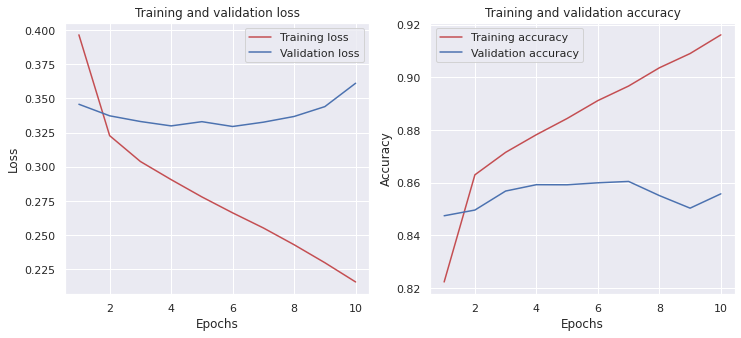

In [92]:
draw_graph(history)

In [93]:
def predict_x(s, corpus):
    
    tensor = []
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=42)

    return tensor

In [94]:
X_test = predict_x(s, test.document.tolist())
y_test = test.label

In [95]:
loaded_model = load_model('best_lstm_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 6s 4ms/step - loss: 0.3373 - acc: 0.8601

 테스트 정확도: 0.8601


# stacked lstm

In [68]:
# 모델 학습
def create_model(vocab_size, word_vector_dim):
    model = Sequential([
        Embedding(vocab_size, word_vector_dim, input_shape=(None,)),
        LSTM(8, return_sequences=True),
        LSTM(16, return_sequences=False),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model

vocab_size = len(s)  # SentencePiece의 vocab size
word_vector_dim = 300
stacked_lstm_model = create_model(vocab_size, word_vector_dim)
stacked_lstm_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 300)         2400000   
_________________________________________________________________
lstm_1 (LSTM)                (None, None, 8)           9888      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                1600      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 2,411,505
Trainable params: 2,411,505
Non-trainable params: 0
_________________________________________________________________


In [69]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('stacked_lstm_best_model.h5', monitor='val_accuracy', mode='max', verbose=1, save_best_only=True)

In [70]:
stacked_lstm_history = stacked_lstm_model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3638/3638 [==============================] - 44s 11ms/step - loss: 0.3752 - accuracy: 0.8303 - val_loss: 0.3395 - val_accuracy: 0.8483

Epoch 00001: val_accuracy improved from -inf to 0.84826, saving model to stacked_lstm_best_model.h5
Epoch 2/20
3638/3638 [==============================] - 41s 11ms/step - loss: 0.2821 - accuracy: 0.8795 - val_loss: 0.3440 - val_accuracy: 0.8512

Epoch 00002: val_accuracy improved from 0.84826 to 0.85118, saving model to stacked_lstm_best_model.h5
Epoch 3/20
3638/3638 [==============================] - 40s 11ms/step - loss: 0.2341 - accuracy: 0.9035 - val_loss: 0.3541 - val_accuracy: 0.8526

Epoch 00003: val_accuracy improved from 0.85118 to 0.85259, saving model to stacked_lstm_best_model.h5
Epoch 4/20
3638/3638 [==============================] - 41s 11ms/step - loss: 0.1897 - accuracy: 0.9250 - val_loss: 0.3905 - val_accuracy: 0.8459

Epoch 00004: val_accuracy did not improve from 0.85259
Epoch 00004: early stopping


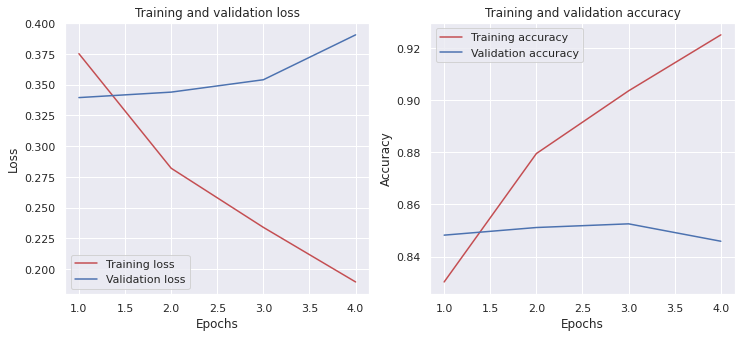

In [74]:
draw_graph(stacked_lstm_history)

In [84]:
loaded_model = load_model('stacked_lstm_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 7s 4ms/step - loss: 0.3564 - accuracy: 0.8517

 테스트 정확도: 0.8517


## 모델링 1D CNN

In [71]:
embedding_dim = 256 # 임베딩 벡터의 차원
dropout_ratio = 0.5 # 드롭아웃 비율
num_filters = 256 # 커널의 수
kernel_size = 3 # 커널의 크기
hidden_units = 128 # 뉴런의 수

cnn_model = Sequential()
cnn_model.add(Embedding(vocab_size, embedding_dim))
cnn_model.add(Dropout(dropout_ratio))
cnn_model.add(Conv1D(num_filters, kernel_size, padding='valid', activation='relu'))
cnn_model.add(GlobalMaxPooling1D())
cnn_model.add(Dense(hidden_units, activation='relu'))
cnn_model.add(Dropout(dropout_ratio))
cnn_model.add(Dense(1, activation='sigmoid'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=3)
mc = ModelCheckpoint('cnn_best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])
cnn_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, None, 256)         2048000   
_________________________________________________________________
dropout (Dropout)            (None, None, 256)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 256)         196864    
_________________________________________________________________
global_max_pooling1d (Global (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                

In [72]:
cnn_history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3638/3638 [==============================] - 47s 7ms/step - loss: 0.4015 - acc: 0.8151 - val_loss: 0.3449 - val_acc: 0.8460

Epoch 00001: val_acc improved from -inf to 0.84599, saving model to cnn_best_model.h5
Epoch 2/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.3115 - acc: 0.8687 - val_loss: 0.3357 - val_acc: 0.8528

Epoch 00002: val_acc improved from 0.84599 to 0.85283, saving model to cnn_best_model.h5
Epoch 3/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.2678 - acc: 0.8894 - val_loss: 0.3354 - val_acc: 0.8546

Epoch 00003: val_acc improved from 0.85283 to 0.85465, saving model to cnn_best_model.h5
Epoch 4/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.2284 - acc: 0.9060 - val_loss: 0.3737 - val_acc: 0.8460

Epoch 00004: val_acc did not improve from 0.85465
Epoch 5/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.1964 - acc: 0.9198 - val_loss: 0.4034 - val_acc: 0.8523

Epoch 

In [73]:
history_dict = history.history
print(history_dict.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


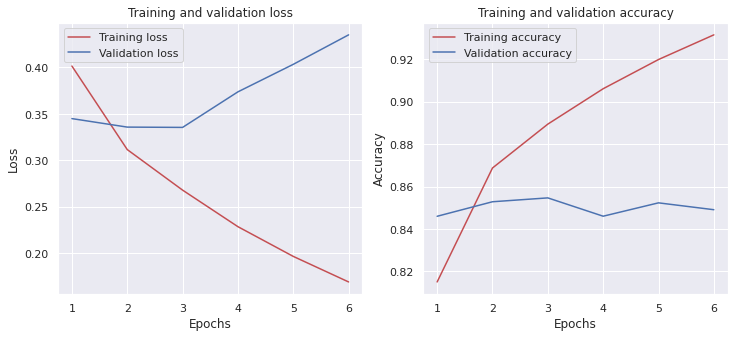

In [75]:
draw_graph(cnn_history)

In [85]:
loaded_model = load_model('cnn_best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 5s 3ms/step - loss: 0.3372 - acc: 0.8557

 테스트 정확도: 0.8557


## Sentence Piece 결과 정리 (test acc 기준)
- lstm model : 0.8601
- stacked lstm model : 0.8517
- 1d cnn model : 0.8557

## 구현된 토크나이저를 적용하여 네이버 영화리뷰 감정 분석 모델을 재학습하기

# KoNLPy 형태소 분석기를 사용한 모델과 성능 비교하기

- 꼬꼬마(kkma)는 java 용량 문제 및 속도가 너무 느려서 수많은 시도 끝에 테스트하기 어렵다는 판단을 내렸다

In [9]:
hannanum = Hannanum()
kkma = Kkma(max_heap_size=2048)
komoran = Komoran()
mecab = Mecab()
okt = Okt()

In [101]:
tokenizer_list = [hannanum, kkma, komoran, mecab, okt]

# kor_text = '별 반개도 아깝다 욕나온다 이응경 길용우 연기생활이몇년인지..정말 발로해도 그것보단 낫겟다 납치.감금만반복반복..이드라마는 가족도없다 연기못하는사람만모엿네'
kor_text = '노래도 너무즐겁고 내용도 아기자기 귀여워요동화같은ㅠ근데 아이들 너무귀엽다♥'

for tokenizer in tokenizer_list:
    print('[{}] \n{}'.format(tokenizer.__class__.__name__, tokenizer.pos(kor_text)))

[Hannanum] 
[('노래', 'N'), ('도', 'J'), ('너무즐겁고', 'N'), ('내용', 'N'), ('도', 'J'), ('아기자기', 'N'), ('귀여워요동화같은ㅠ근데', 'N'), ('아이들', 'N'), ('너무귀엽다♥', 'N')]
[Kkma] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'ECE'), ('내용', 'NNG'), ('도', 'JX'), ('아기자기', 'MAG'), ('귀엽', 'VA'), ('어', 'ECS'), ('요동', 'NNG'), ('화', 'XSN'), ('같', 'VA'), ('은', 'ETD'), ('ㅠ', 'UN'), ('그', 'VA'), ('ㄴ데', 'ECE'), ('아이', 'NNG'), ('들', 'XSN'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'ECS'), ('♥', 'SW')]
[Komoran] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'EC'), ('내용', 'NNG'), ('도', 'JX'), ('아기자기', 'MAG'), ('귀여워요동화같으뉴근데', 'NA'), ('아이들', 'NNP'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'EC'), ('♥', 'SW')]
[Mecab] 
[('노래', 'NNG'), ('도', 'JX'), ('너무', 'MAG'), ('즐겁', 'VA'), ('고', 'EC'), ('내용', 'NNG'), ('도', 'JX'), ('아기', 'NNG'), ('자기', 'NP'), ('귀여워', 'VA+EC'), ('요동', 'NNG'), ('화', 'XSN'), ('같', 'VA'), ('은', 'ETM'), ('ㅠ근데', 'UNKNOWN'), ('아이', 'NNG'), ('들', 'XSN'), ('너무', 'MAG'), ('귀엽', 'VA'), ('다', 'E

In [ ]:
# kkma_doc = train.document.progress_apply(lambda x: kkma.pos(x)).tolist()

In [10]:
train.columns

Index(['id', 'document', 'label'], dtype='object')

In [43]:
tokenizer_list = [hannanum, komoran, mecab, okt]

for tokenizer in tokenizer_list:
    name = str(tokenizer.__class__.__name__)
    print(f'[{name}]')
    
    if name not in train.columns:
        train[f'{name}'] = train.document.progress_apply(lambda x: tokenizer.morphs(x))
    
        if name == 'Okt':
            train[f'{name}_stem'] = train.document.progress_apply(lambda x: tokenizer.morphs(x, stem=True))
        
        train.to_csv('data_preprocessed_morph_final.csv', index=False)
    else:
        pass

[Hannanum]


  5%|▍         | 6936/145510 [00:48<12:35, 183.30it/s] java.lang.ArrayIndexOutOfBoundsException: Index 2046 out of bounds for length 2046
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.MorphAnalyzer.ChartMorphAnalyzer.MorphemeChart.addMorpheme(MorphemeChart.java:191)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.MorphAnalyzer.ChartMorphAnalyzer.MorphemeChart.analyzeUnknown(MorphemeChart.java:451)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.MorphAnalyzer.ChartMorphAnalyzer.MorphemeChart.analyze(MorphemeChart.java:257)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.MorphAnalyzer.ChartMorphAnalyzer.ChartMorphAnalyzer.processEojeol(ChartMorphAnalyzer.java:133)
	at kr.ac.kaist.swrc.jhannanum.plugin.MajorPlugin.MorphAnalyzer.ChartMorphAnalyzer.ChartMorphAnalyzer.morphAnalyze(ChartMorphAnalyzer.java:158)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyzeInSingleThread(Workflow.java:825)
	at kr.ac.kaist.swrc.jhannanum.hannanum.Workflow.analyze(Workflow.java:521)
	at kr.lu

[Komoran]


100%|██████████| 145510/145510 [02:41<00:00, 901.48it/s] 


[Mecab]


100%|██████████| 145510/145510 [00:22<00:00, 6593.74it/s] 


[Okt]


100%|██████████| 145510/145510 [20:44<00:00, 116.96it/s]


In [45]:
train.to_csv('data_preprocessed_morph_final.csv', index=False)

In [47]:
train.head()

,id,document,label,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증나네요, 목소리]","[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보, 이, 고, 초딩영화줄오버연기조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"
2,10265843,너무재밓었다그래서보는것을추천한다,0,[너무재밓었다그래서보는것을추천한다],[너무재밓었다그래서보는것을추천한다],"[너무, 재, 밓었다그래서보는것을추천한다]","[너, 무재, 밓었, 다그, 래서, 보는것을, 추천, 한, 다]","[너, 무재, 밓었, 다그, 래서, 보다, 추천, 한, 다]"
3,9045019,교도소 이야기구먼 솔직히 재미는 없다평점 조정,0,"[교도소, 이야기구먼, 솔직히, 재미, 는, 없다평점, 조정]","[교도소, 이야기, 이, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없, 다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직히, 재미, 는, 없다, 평점, 조정]","[교도소, 이야기, 구먼, 솔직하다, 재미, 는, 없다, 평점, 조정]"
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화스파이더맨에서 늙어보이기만 했던 커스틴 던...,1,"[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보이, 었던, 영화스파이더맨, 에서...","[사이몬페그의, 익살, 스럽, ㄴ, 연기, 가, 돋보이, 었, 던, 영화, 스파이더...","[사이몬페그, 의, 익살, 스런, 연기, 가, 돋보였, 던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스런, 연기, 가, 돋보였던, 영화, 스파이더맨, 에...","[사이, 몬페, 그, 의, 익살스럽다, 연기, 가, 돋보이다, 영화, 스파이더맨, ..."


## 형태소 분석기 별 성능 비교

In [52]:
test = preprocessing(test)

/tmp/ipykernel_2247/3900349715.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣0-9♥♡乃ㄳㅄ ]","") # 정규 표현식 수행
/tmp/ipykernel_2247/3900349715.py:3: FutureWarning: The default value of regex will change from True to False in a future version.
  train[col] = train[col].str.replace('^ +', "") # 공백은 empty 값으로 변경


In [54]:
tokenizer_list = [hannanum, komoran, mecab, okt]

for tokenizer in tokenizer_list:
    name = str(tokenizer.__class__.__name__)
    print(f'[{name}]')
    
    if name not in test.columns:
        test[f'{name}'] = test.document.progress_apply(lambda x: tokenizer.morphs(x))
    
        if name == 'Okt':
            test[f'{name}_stem'] = test.document.progress_apply(lambda x: tokenizer.morphs(x, stem=True))
        
        test.to_csv('test_data_preprocessed_morph_final.csv', index=False)
    else:
        pass

[Hannanum]


100%|██████████| 48907/48907 [08:53<00:00, 91.60it/s] 


[Komoran]


100%|██████████| 48907/48907 [01:24<00:00, 575.54it/s] 


[Mecab]


100%|██████████| 48907/48907 [00:08<00:00, 5827.47it/s] 


[Okt]


100%|██████████| 48907/48907 [10:45<00:00, 75.71it/s] 


In [57]:
tokenizer_list

In [60]:
train.head(2)

,id,document,label,Hannanum,Komoran,Mecab,Okt,Okt_stem
0,9976970,아 더빙 진짜 짜증나네요 목소리,0,"[아, 더빙, 진짜, 짜증나, 네, 요, 목소리]","[아, 더빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더, 빙, 진짜, 짜증, 나, 네요, 목소리]","[아, 더빙, 진짜, 짜증나네요, 목소리]","[아, 더빙, 진짜, 짜증나다, 목소리]"
1,3819312,흠포스터보고 초딩영화줄오버연기조차 가볍지 않구나,1,"[흠포스터보, 이, 고, 초딩영화줄오버연기조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍, 지, 않, 구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍지, 않구나]","[흠, 포스터, 보고, 초딩, 영화, 줄, 오버, 연기, 조차, 가볍다, 않다]"


In [61]:
from tensorflow.keras.preprocessing.text import Tokenizer

In [66]:
# 불용어 정의
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','을','으로','자',
             '에','와','한','하다','하','어','다','네','요','에서','에게','게','ㄴ','에서','고','로']

In [69]:
def compare_morphs(df, test, tokenizer, stopwords=stopwords):
    
    col = tokenizer.__class__.__name__

    X_data = df[col].apply(lambda x: [str(i) for i in x]).dropna().tolist()
    y_data = df['label'].dropna()

    print(len(X_data), len(y_data))
    
    # 형태소 분석
    #test_morphs = test.document.progress_apply(lambda x: tokenizer.morphs(x))
    test_morphs = test[col].copy()
    test_morphs = test_morphs.progress_apply(lambda x: [str(word) for word in x if not word in stopwords])

    # 토큰화
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(X_data)

    print(len(tokenizer.word_index))

    # 등장 빈도수가 3회 미만인 단어들의 분포 확인

    threshold = 3
    total_cnt = len(tokenizer.word_index) # 단어의 수
    rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
    total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
    rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

    # 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
    for key, value in tokenizer.word_counts.items():
        total_freq = total_freq + value

        # 단어의 등장 빈도수가 threshold보다 작으면
        if(value < threshold):
            rare_cnt = rare_cnt + 1
            rare_freq = rare_freq + value

    print('단어 집합(vocabulary)의 크기 :',total_cnt)
    print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
    print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
    print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

    # 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
    # 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
    # 0번 패딩 토큰을 고려하여 + 1

    vocab_size = total_cnt - rare_cnt + 1
    print('단어 집합의 크기 :',vocab_size)

    # 이를 케라스 토크나이저의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환
    
    tokenizer = Tokenizer(vocab_size) 
    tokenizer.fit_on_texts(X_data)
    X_train = tokenizer.texts_to_sequences(X_data)
    X_test = tokenizer.texts_to_sequences(test_morphs)
    
    return X_train, X_test, tokenizer, vocab_size

In [71]:
X_train, X_test, tokenizer, vocab_size = compare_morphs(train, test, okt)

145510 145510


100%|██████████| 48907/48907 [00:00<00:00, 100372.13it/s]


101541
단어 집합(vocabulary)의 크기 : 101541
등장 빈도가 2번 이하인 희귀 단어의 수: 68875
단어 집합에서 희귀 단어의 비율: 67.82974365034814
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.266309924278831
단어 집합의 크기 : 32667


In [73]:
y_train = y_data.tolist()

In [74]:
len(X_train), len(y_train)

(145510, 145510)

In [75]:
def drop_empty_list(X_train, y_train):
    # 각 샘플들의 길이를 확인해서 길이가 0인 샘플들의 인덱스 받아오기
    drop_train = [index for index, sentence in enumerate(X_train) if len(sentence) < 1]
    print(f'빈 샘플 수 : {len(drop_train)}')

    # 빈 샘플 제거
    X_train = np.delete(X_train, drop_train, axis=0)
    y_train = np.delete(y_train, drop_train, axis=0)
    print(f'빈 샘플 제거 후 남은 X train data : {len(X_train)}')
    print(f'빈 샘플 제거 후 남은 y train data : {len(y_train)}')
    return X_train, y_train

In [76]:
X_train, y_train = drop_empty_list(X_train, y_train)

빈 샘플 수 : 395
빈 샘플 제거 후 남은 X train data : 145115
빈 샘플 제거 후 남은 y train data : 145115


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 72
리뷰의 평균 길이 : 12.69824621851635


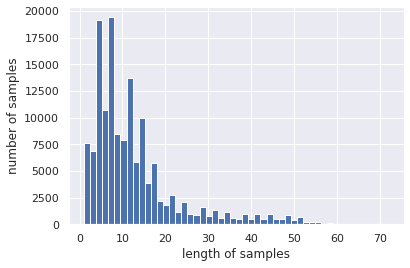

In [77]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [78]:
# 전체 샘플 중 길이가 max_len 이하인 샘플의 비율이 몇 %인지 확인

def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))*100))

In [80]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 98.95600041346519


In [97]:
def padding_and_split(X_train, X_test, y_train, max_len):
    X_train = pad_sequences(X_train, maxlen = max_len)
    X_test = pad_sequences(X_test, maxlen = max_len)

    X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=True,
                                                      stratify=y_train, random_state=777)
    return X_train, X_val, y_train, y_val, X_test

In [98]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)

In [86]:
vocab_size

32667

In [87]:
embedding_dim = 100

In [88]:
def lstm_model(vocab_size, embedding_dim, optimizer='rmsprop'):
    model = Sequential([
        Embedding(vocab_size, embedding_dim),
        LSTM(128),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['acc'])
    return model

In [91]:
model = lstm_model(vocab_size, embedding_dim)

In [92]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_okt.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [93]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3628/3628 [==============================] - 64s 9ms/step - loss: 0.3938 - acc: 0.8214 - val_loss: 0.3468 - val_acc: 0.8499

Epoch 00001: val_acc improved from -inf to 0.84991, saving model to best_lstm_model_okt.h5
Epoch 2/20
3628/3628 [==============================] - 31s 9ms/step - loss: 0.3140 - acc: 0.8669 - val_loss: 0.3314 - val_acc: 0.8596

Epoch 00002: val_acc improved from 0.84991 to 0.85956, saving model to best_lstm_model_okt.h5
Epoch 3/20
3628/3628 [==============================] - 31s 8ms/step - loss: 0.2832 - acc: 0.8833 - val_loss: 0.3297 - val_acc: 0.8633

Epoch 00003: val_acc improved from 0.85956 to 0.86335, saving model to best_lstm_model_okt.h5
Epoch 4/20
3628/3628 [==============================] - 31s 9ms/step - loss: 0.2633 - acc: 0.8933 - val_loss: 0.3203 - val_acc: 0.8675

Epoch 00004: val_acc improved from 0.86335 to 0.86752, saving model to best_lstm_model_okt.h5
Epoch 5/20
3628/3628 [==============================] - 32s 9ms/step - loss: 0.2468

In [120]:
def draw_graph(history):
    history_dict = history.history
    try:
        acc = history_dict['accuracy']
        val_acc = history_dict['val_accuracy']
    except:
        acc = history_dict['acc']
        val_acc = history_dict['val_acc']
    loss = history_dict['loss']
    val_loss = history_dict['val_loss']

    epochs = range(1, len(acc) + 1)

    fig = plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

In [ ]:
draw_graph(history)

In [100]:
X_test.shape

(48907, 50)

In [105]:
y_test = np.array(test.label)

In [106]:
# 테스트 정확도 측정

loaded_model = load_model('best_lstm_model_okt.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 6s 4ms/step - loss: 0.3331 - acc: 0.8586

 테스트 정확도: 0.8586


## 한나눔 성능

In [108]:
X_train, X_test, tokenizer, vocab_size = compare_morphs(train, test, hannanum)

145510 145510


100%|██████████| 48907/48907 [00:00<00:00, 62183.11it/s]


182198
단어 집합(vocabulary)의 크기 : 182198
등장 빈도가 2번 이하인 희귀 단어의 수: 158670
단어 집합에서 희귀 단어의 비율: 87.08657614243845
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 8.200177255847207
단어 집합의 크기 : 23529


In [110]:
y_train = y_data.tolist()

In [111]:
X_train, y_train = drop_empty_list(X_train, y_train)

빈 샘플 수 : 5513
빈 샘플 제거 후 남은 X train data : 139997
빈 샘플 제거 후 남은 y train data : 139997


리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 13.776288063315642


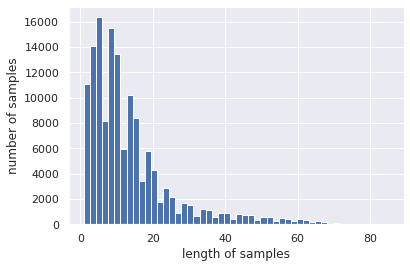

In [112]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [113]:
max_len = 50
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 50 이하인 샘플의 비율: 97.21922612627414


In [114]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)

In [116]:
embedding_dim = 100

In [117]:
model = lstm_model(vocab_size, embedding_dim)

In [118]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint('best_lstm_model_hannanum.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [119]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3500/3500 [==============================] - 41s 10ms/step - loss: 0.4426 - acc: 0.7917 - val_loss: 0.3972 - val_acc: 0.8146

Epoch 00001: val_acc improved from -inf to 0.81457, saving model to best_lstm_model_hannanum.h5
Epoch 2/20
3500/3500 [==============================] - 29s 8ms/step - loss: 0.3737 - acc: 0.8340 - val_loss: 0.3710 - val_acc: 0.8305

Epoch 00002: val_acc improved from 0.81457 to 0.83054, saving model to best_lstm_model_hannanum.h5
Epoch 3/20
3500/3500 [==============================] - 29s 8ms/step - loss: 0.3414 - acc: 0.8521 - val_loss: 0.3632 - val_acc: 0.8369

Epoch 00003: val_acc improved from 0.83054 to 0.83686, saving model to best_lstm_model_hannanum.h5
Epoch 4/20
3500/3500 [==============================] - 30s 8ms/step - loss: 0.3209 - acc: 0.8611 - val_loss: 0.3695 - val_acc: 0.8359

Epoch 00004: val_acc did not improve from 0.83686
Epoch 5/20
3500/3500 [==============================] - 27s 8ms/step - loss: 0.3057 - acc: 0.8698 - val_loss: 0

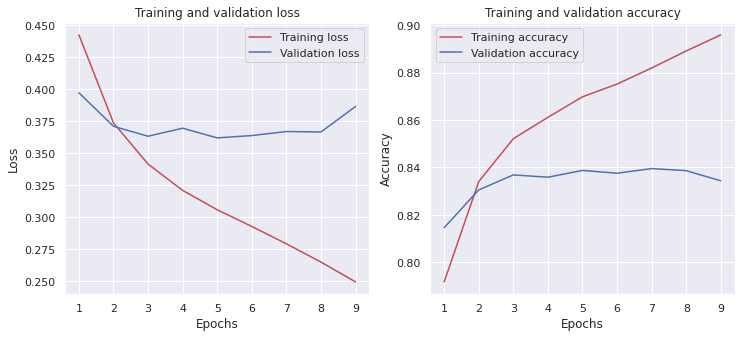

In [121]:
draw_graph(history)

In [122]:
X_test.shape

(48907, 50)

In [123]:
y_test = np.array(test.label)

In [125]:
y_test.shape

(48907,)

In [126]:
# 테스트 정확도 측정

loaded_model = load_model('best_lstm_model_hannanum.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 4s 3ms/step - loss: 0.4043 - acc: 0.8199

 테스트 정확도: 0.8199


## Komoran 성능

In [148]:
name = komoran.__class__.__name__.lower()

In [137]:
X_train, X_test, tokenizer, vocab_size = compare_morphs(train, test, komoran)

145510 145510


100%|██████████| 48907/48907 [00:00<00:00, 73255.75it/s]


55043
단어 집합(vocabulary)의 크기 : 55043
등장 빈도가 2번 이하인 희귀 단어의 수: 36854
단어 집합에서 희귀 단어의 비율: 66.95492614864742
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6391542779794273
단어 집합의 크기 : 18190


In [138]:
y_train = y_data.tolist()

In [139]:
X_train, y_train = drop_empty_list(X_train, y_train)

빈 샘플 수 : 2278
빈 샘플 제거 후 남은 X train data : 143232
빈 샘플 제거 후 남은 y train data : 143232


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 104
리뷰의 평균 길이 : 17.77689343163539


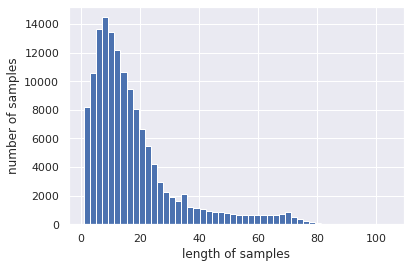

In [140]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [142]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 98.85500446827524


In [143]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)

In [144]:
embedding_dim = 100

In [145]:
model = lstm_model(vocab_size, embedding_dim)

In [149]:
# 모델 검증

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_lstm_model_{name}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

In [150]:
# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3581/3581 [==============================] - 28s 7ms/step - loss: 0.3915 - acc: 0.8226 - val_loss: 0.3689 - val_acc: 0.8403

Epoch 00001: val_acc improved from -inf to 0.84026, saving model to best_lstm_model_komoran.h5
Epoch 2/20
3581/3581 [==============================] - 24s 7ms/step - loss: 0.3290 - acc: 0.8582 - val_loss: 0.3418 - val_acc: 0.8544

Epoch 00002: val_acc improved from 0.84026 to 0.85437, saving model to best_lstm_model_komoran.h5
Epoch 3/20
3581/3581 [==============================] - 24s 7ms/step - loss: 0.3009 - acc: 0.8733 - val_loss: 0.3213 - val_acc: 0.8633

Epoch 00003: val_acc improved from 0.85437 to 0.86330, saving model to best_lstm_model_komoran.h5
Epoch 4/20
3581/3581 [==============================] - 24s 7ms/step - loss: 0.2800 - acc: 0.8843 - val_loss: 0.3175 - val_acc: 0.8650

Epoch 00004: val_acc improved from 0.86330 to 0.86498, saving model to best_lstm_model_komoran.h5
Epoch 5/20
3581/3581 [==============================] - 24s 7ms/ste

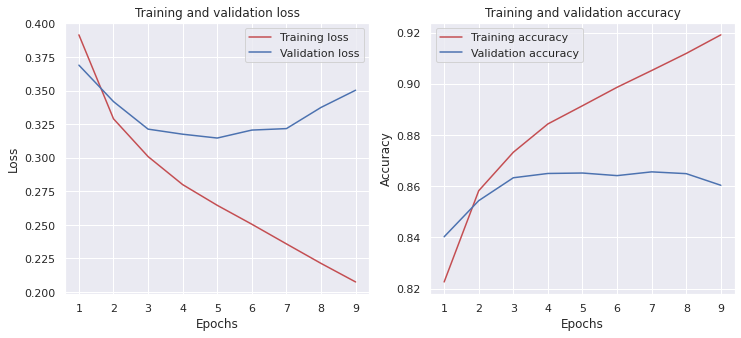

In [151]:
draw_graph(history)

In [152]:
X_test.shape

(48907, 70)

In [153]:
y_test = np.array(test.label)

In [125]:
y_test.shape

(48907,)

In [154]:
# 테스트 정확도 측정

loaded_model = load_model(f'best_lstm_model_{name}.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 5s 3ms/step - loss: 0.3418 - acc: 0.8544

 테스트 정확도: 0.8544


# Mecab 성능

In [155]:
name = mecab.__class__.__name__.lower()

X_train, X_test, tokenizer, vocab_size = compare_morphs(train, test, mecab)
y_train = y_data.tolist()
X_train, y_train = drop_empty_list(X_train, y_train)

145510 145510


100%|██████████| 48907/48907 [00:00<00:00, 86299.29it/s]


50204
단어 집합(vocabulary)의 크기 : 50204
등장 빈도가 2번 이하인 희귀 단어의 수: 28464
단어 집합에서 희귀 단어의 비율: 56.69667755557326
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.4590719384795277
단어 집합의 크기 : 21741
빈 샘플 수 : 202
빈 샘플 제거 후 남은 X train data : 145308
빈 샘플 제거 후 남은 y train data : 145308


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 96
리뷰의 평균 길이 : 16.494226057753185


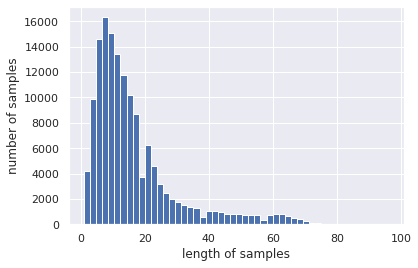

In [156]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [157]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.68549563685413


In [158]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)

In [159]:
embedding_dim = 100

model = lstm_model(vocab_size, embedding_dim)

# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_lstm_model_{name}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3633/3633 [==============================] - 26s 7ms/step - loss: 0.3820 - acc: 0.8297 - val_loss: 0.3341 - val_acc: 0.8556

Epoch 00001: val_acc improved from -inf to 0.85555, saving model to best_lstm_model_mecab.h5
Epoch 2/20
3633/3633 [==============================] - 25s 7ms/step - loss: 0.3172 - acc: 0.8651 - val_loss: 0.3131 - val_acc: 0.8652

Epoch 00002: val_acc improved from 0.85555 to 0.86518, saving model to best_lstm_model_mecab.h5
Epoch 3/20
3633/3633 [==============================] - 24s 7ms/step - loss: 0.2881 - acc: 0.8804 - val_loss: 0.3054 - val_acc: 0.8668

Epoch 00003: val_acc improved from 0.86518 to 0.86684, saving model to best_lstm_model_mecab.h5
Epoch 4/20
3633/3633 [==============================] - 24s 7ms/step - loss: 0.2669 - acc: 0.8911 - val_loss: 0.3059 - val_acc: 0.8730

Epoch 00004: val_acc improved from 0.86684 to 0.87300, saving model to best_lstm_model_mecab.h5
Epoch 5/20
3633/3633 [==============================] - 25s 7ms/step - loss

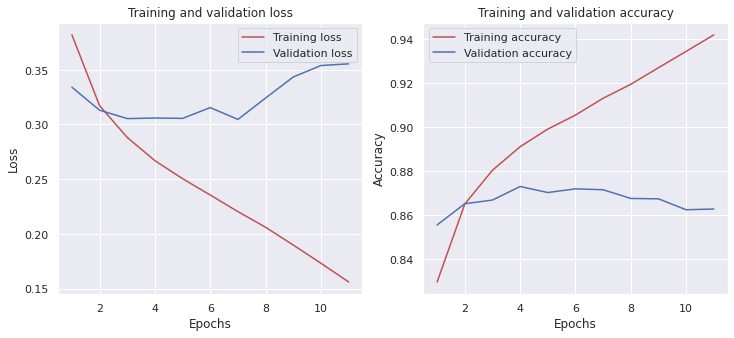

In [160]:
draw_graph(history)

In [161]:
X_test.shape

(48907, 70)

In [162]:
y_test = np.array(test.label)

In [163]:
y_test.shape

(48907,)

In [164]:
# 테스트 정확도 측정

loaded_model = load_model(f'best_lstm_model_{name}.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 5s 3ms/step - loss: 0.3242 - acc: 0.8649

 테스트 정확도: 0.8649


## Okt (stem=True) 성능

In [167]:
df = train.copy()

In [168]:
col = 'Okt_stem'
name = col.lower()

X_data = df[col].apply(lambda x: [str(i) for i in x]).dropna().tolist()
y_data = df['label'].dropna()

print(len(X_data), len(y_data))

# 형태소 분석
#test_morphs = test.document.progress_apply(lambda x: tokenizer.morphs(x))
test_morphs = test[col].copy()
test_morphs = test_morphs.progress_apply(lambda x: [str(word) for word in x if not word in stopwords])

# 토큰화
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_data)

print(len(tokenizer.word_index))

# 등장 빈도수가 3회 미만인 단어들의 분포 확인

threshold = 3
total_cnt = len(tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :',total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

# 등장 빈도수가 2이하인 단어들의 수를 제외한 단어의 개수를 단어 집합의 최대 크기로 제한
# 전체 단어 개수 중 빈도수 2이하인 단어는 제거.
# 0번 패딩 토큰을 고려하여 + 1

vocab_size = total_cnt - rare_cnt + 1
print('단어 집합의 크기 :',vocab_size)

# 이를 케라스 토크나이저의 인자로 넘겨 텍스트 시퀀스를 숫자 시퀀스로 변환

tokenizer = Tokenizer(vocab_size) 
tokenizer.fit_on_texts(X_data)
X_train = tokenizer.texts_to_sequences(X_data)
X_test = tokenizer.texts_to_sequences(test_morphs)

145510 145510


100%|██████████| 48907/48907 [00:00<00:00, 131441.29it/s]


45557
단어 집합(vocabulary)의 크기 : 45557
등장 빈도가 2번 이하인 희귀 단어의 수: 25753
단어 집합에서 희귀 단어의 비율: 56.52918322101982
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 1.6384346628914317
단어 집합의 크기 : 19805


In [169]:
y_train = y_data.tolist()
X_train, y_train = drop_empty_list(X_train, y_train)

빈 샘플 수 : 241
빈 샘플 제거 후 남은 X train data : 145269
빈 샘플 제거 후 남은 y train data : 145269


/opt/conda/lib/python3.9/site-packages/numpy/lib/function_base.py:4454: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  arr = asarray(arr)


리뷰의 최대 길이 : 75
리뷰의 평균 길이 : 13.032980195361707


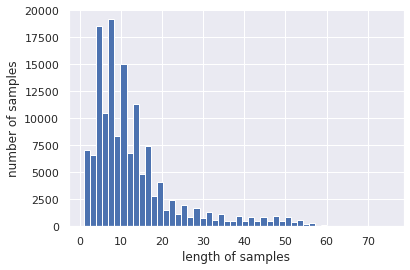

In [170]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show();

In [171]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.99449297510137


In [172]:
X_train, X_val, y_train, y_val, X_test = padding_and_split(X_train, X_test, y_train, max_len)

In [173]:
embedding_dim = 100

model = lstm_model(vocab_size, embedding_dim)

# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_lstm_model_{name}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3632/3632 [==============================] - 37s 9ms/step - loss: 0.3859 - acc: 0.8261 - val_loss: 0.3415 - val_acc: 0.8532

Epoch 00001: val_acc improved from -inf to 0.85317, saving model to best_lstm_model_okt_stem.h5
Epoch 2/20
3632/3632 [==============================] - 25s 7ms/step - loss: 0.3230 - acc: 0.8621 - val_loss: 0.3261 - val_acc: 0.8597

Epoch 00002: val_acc improved from 0.85317 to 0.85971, saving model to best_lstm_model_okt_stem.h5
Epoch 3/20
3632/3632 [==============================] - 25s 7ms/step - loss: 0.2975 - acc: 0.8747 - val_loss: 0.3155 - val_acc: 0.8632

Epoch 00003: val_acc improved from 0.85971 to 0.86315, saving model to best_lstm_model_okt_stem.h5
Epoch 4/20
3632/3632 [==============================] - 25s 7ms/step - loss: 0.2796 - acc: 0.8840 - val_loss: 0.3192 - val_acc: 0.8649

Epoch 00004: val_acc improved from 0.86315 to 0.86494, saving model to best_lstm_model_okt_stem.h5
Epoch 5/20
3632/3632 [==============================] - 25s 7ms

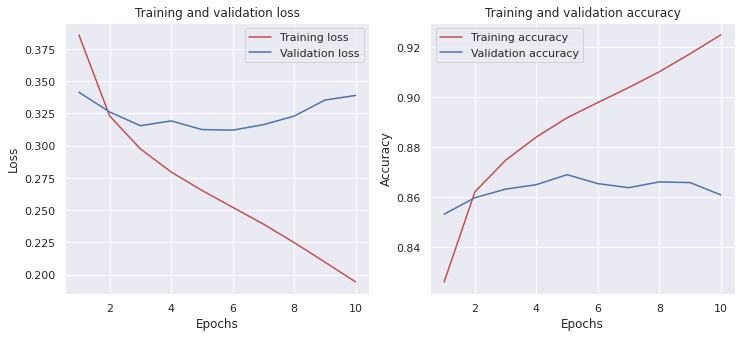

In [174]:
draw_graph(history)

In [175]:
X_test.shape

(48907, 70)

In [176]:
y_test = np.array(test.label)

In [177]:
y_test.shape

(48907,)

In [178]:
# 테스트 정확도 측정

loaded_model = load_model(f'best_lstm_model_{name}.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 5s 3ms/step - loss: 0.3318 - acc: 0.8613

 테스트 정확도: 0.8613


## Sentence Piece 결과 정리 (test acc 기준)
- lstm model : 0.8601
- stacked lstm model : 0.8517
- 1d cnn model : 0.8557

## 최종 형태소별 성능 정리 ( lstm model )

- hannanum : 0.8199 (빈 샘플 수 : 5513)
- komoran : 0.8544 (빈 샘플 수 : 2278)
- mecab : 0.8649 (빈 샘플 수 : 202)
- okt
    - stem = False : 0.8586 (빈 샘플 수 : 395)
    - stem = True : 0.8613 (빈 샘플 수 : 241)


- 빈 샘플 수에 비례해 성능이 좋아지는 것을 볼 수 있다
- 이에 따라 성능 향상에 토큰을 잘 나누는 것이 매우 중요한 요소로 보인다

## SentencePiece 모델의 model_type, vocab_size 등을 변경해 가면서 성능 개선 여부 확인하기

- mecab의 vocab size가 21741이었으므로 이를 따라 해본다

In [180]:
temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp'

vocab_size = 21741

with open(temp_file, 'w') as f:
    for row in corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={}'.format(temp_file, vocab_size)    
)

sentencepiece_trainer.cc(177) LOG(INFO) Running command: --input=/aiffel/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp --model_prefix=korean_spm --vocab_size=21741
sentencepiece_trainer.cc(77) LOG(INFO) Starts training with : 
trainer_spec {
  input: /aiffel/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp
  input_format: 
  model_prefix: korean_spm
  model_type: UNIGRAM
  vocab_size: 21741
  self_test_sample_size: 0
  character_coverage: 0.9995
  input_sentence_size: 0
  shuffle_input_sentence: 1
  seed_sentencepiece_size: 1000000
  shrinking_factor: 0.75
  max_sentence_length: 4192
  num_threads: 16
  num_sub_iterations: 2
  max_sentencepiece_length: 16
  split_by_unicode_script: 1
  split_by_number: 1
  split_by_whitespace: 1
  split_digits: 0
  treat_whitespace_as_suffix: 0
  allow_whitespace_only_pieces: 0
  required_chars: 
  byte_fallback: 0
  vocabulary_output_piece_score: 1
  train_extremely_large_corpus: 0
  hard_vocab_limit: 1
  use_all_vocab: 0
  unk_

In [186]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [187]:
test_data = test.document.tolist()

In [188]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
 
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [189]:
tensor, word_index, index_word = sp_tokenize(s, corpus)

In [190]:
num_tokens = [len(tokens) for tokens in tensor]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 13.056504707580235
토큰 길이 최대: 102
토큰 길이 표준편차: 11.404279911097516
설정 최대 길이: 35
전체 문장의 0.9358875678647516%가 설정값인 35에 포함됩니다.


In [191]:
max_len = 60
below_threshold_len(max_len, tensor)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 99.60621263143426


In [192]:
X = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=60)

In [193]:
X.shape

(145510, 60)

In [194]:
train.label.shape

(145510,)

In [195]:
y = train['label']

In [196]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [198]:
name = 'sentencepiece_10000'

In [199]:
embedding_dim = 100

model = lstm_model(vocab_size, embedding_dim)

# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_lstm_model_{name}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Epoch 1/20
3638/3638 [==============================] - 35s 8ms/step - loss: 0.4049 - acc: 0.8146 - val_loss: 0.3559 - val_acc: 0.8458

Epoch 00001: val_acc improved from -inf to 0.84578, saving model to best_lstm_model_sentencepiece_10000.h5
Epoch 2/20
3638/3638 [==============================] - 23s 6ms/step - loss: 0.3118 - acc: 0.8703 - val_loss: 0.3337 - val_acc: 0.8544

Epoch 00002: val_acc improved from 0.84578 to 0.85444, saving model to best_lstm_model_sentencepiece_10000.h5
Epoch 3/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.2839 - acc: 0.8831 - val_loss: 0.3274 - val_acc: 0.8590

Epoch 00003: val_acc improved from 0.85444 to 0.85905, saving model to best_lstm_model_sentencepiece_10000.h5
Epoch 4/20
3638/3638 [==============================] - 23s 6ms/step - loss: 0.2647 - acc: 0.8925 - val_loss: 0.3240 - val_acc: 0.8597

Epoch 00004: val_acc improved from 0.85905 to 0.85970, saving model to best_lstm_model_sentencepiece_10000.h5
Epoch 5/20
3638/363

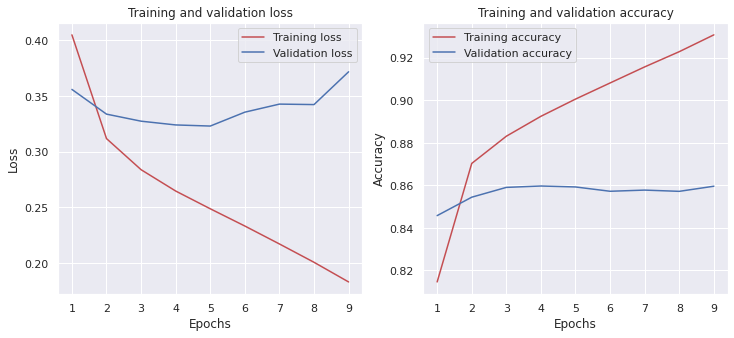

In [200]:
draw_graph(history)

In [201]:
def predict_x(s, corpus):
    
    tensor = []
    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=42)

    return tensor

In [202]:
X_test = predict_x(s, test.document.tolist())
y_test = test.label

In [203]:
loaded_model = load_model('best_lstm_model_sentencepiece_10000.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 4s 3ms/step - loss: 0.3260 - acc: 0.8608

 테스트 정확도: 0.8608


## bpe

In [207]:
import sentencepiece as spm
import os

temp_file = os.getenv('HOME')+'/aiffel/sp_tokenizer/data/korean-english-nsmc.train.ko.temp'

vocab_size = 8000

with open(temp_file, 'w') as f:
    for row in corpus:   # 이전에 나왔던 정제했던 corpus를 활용해서 진행해야 합니다.
        f.write(str(row) + '\n')

spm.SentencePieceTrainer.Train(
    '--input={} --model_prefix=korean_spm --vocab_size={} --model_type=bpe'.format(temp_file, vocab_size)    
)

In [208]:
s = spm.SentencePieceProcessor()
s.Load('korean_spm.model')

True

In [209]:
test_data = test.document.tolist()

In [210]:
def sp_tokenize(s, corpus): 

    tensor = []

    for sen in corpus:
        tensor.append(s.EncodeAsIds(sen))

    with open("./korean_spm.vocab", 'r') as f:
        vocab = f.readlines()
 
    word_index = {}
    index_word = {}

    for idx, line in enumerate(vocab):
        word = line.split("\t")[0]

        word_index.update({word:idx})
        index_word.update({idx:word})

    #tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')

    return tensor, word_index, index_word

In [211]:
tensor, word_index, index_word = sp_tokenize(s, corpus)

In [212]:
num_tokens = [len(tokens) for tokens in tensor]
num_tokens = np.array(num_tokens)

# 평균값, 최댓값, 표준편차
print(f"토큰 길이 평균: {np.mean(num_tokens)}")
print(f"토큰 길이 최대: {np.max(num_tokens)}")
print(f"토큰 길이 표준편차: {np.std(num_tokens)}")

max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print(f'설정 최대 길이: {maxlen}')
print(f'전체 문장의 {np.sum(num_tokens < max_tokens) / len(num_tokens)}%가 설정값인 {maxlen}에 포함됩니다.')

토큰 길이 평균: 15.207222871280324
토큰 길이 최대: 111
토큰 길이 표준편차: 13.248601392663101
설정 최대 길이: 41
전체 문장의 0.9364511030169748%가 설정값인 41에 포함됩니다.


In [213]:
max_len = 60
below_threshold_len(max_len, tensor)

전체 샘플 중 길이가 60 이하인 샘플의 비율: 98.4262250017181


In [214]:
X = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='pre', maxlen=60)

In [215]:
X.shape

(145510, 60)

In [216]:
train.label.shape

(145510,)

In [217]:
y = train['label']

In [218]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=42)

In [219]:
name = 'sentencepiece_bpe'

In [220]:
embedding_dim = 100

model = lstm_model(vocab_size, embedding_dim)

# 모델 검증
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
mc = ModelCheckpoint(f'best_lstm_model_{name}.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

# 모델 훈련
history = model.fit(X_train, y_train, epochs=20, validation_data=(X_val, y_val), callbacks=[es, mc])

Exception ignored in: <function ScopedTFGraph.__del__ at 0x7e50541621f0>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/tensorflow/python/framework/c_api_util.py", line 58, in __del__
    self.deleter(self.graph)
AttributeError: deleter


Epoch 1/20
3638/3638 [==============================] - 25s 7ms/step - loss: 0.3944 - acc: 0.8217 - val_loss: 0.3624 - val_acc: 0.8423

Epoch 00001: val_acc improved from -inf to 0.84228, saving model to best_lstm_model_sentencepiece_bpe.h5
Epoch 2/20
3638/3638 [==============================] - 23s 6ms/step - loss: 0.3225 - acc: 0.8620 - val_loss: 0.3330 - val_acc: 0.8533

Epoch 00002: val_acc improved from 0.84228 to 0.85327, saving model to best_lstm_model_sentencepiece_bpe.h5
Epoch 3/20
3638/3638 [==============================] - 24s 7ms/step - loss: 0.3031 - acc: 0.8721 - val_loss: 0.3278 - val_acc: 0.8554

Epoch 00003: val_acc improved from 0.85327 to 0.85537, saving model to best_lstm_model_sentencepiece_bpe.h5
Epoch 4/20
3638/3638 [==============================] - 24s 6ms/step - loss: 0.2880 - acc: 0.8802 - val_loss: 0.3299 - val_acc: 0.8571

Epoch 00004: val_acc improved from 0.85537 to 0.85705, saving model to best_lstm_model_sentencepiece_bpe.h5
Epoch 5/20
3638/3638 [=====

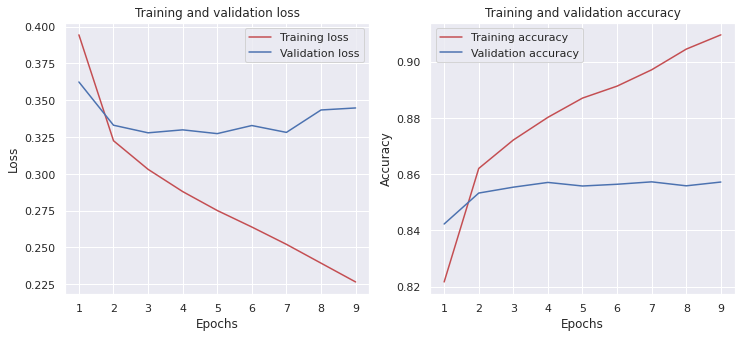

In [221]:
draw_graph(history)

In [222]:
X_test = predict_x(s, test.document.tolist())
y_test = test.label

In [223]:
loaded_model = load_model('best_lstm_model_sentencepiece_bpe.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1529/1529 [==============================] - 4s 3ms/step - loss: 0.3280 - acc: 0.8601

 테스트 정확도: 0.8601


In [243]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_auc_score

In [225]:
pred = loaded_model.predict(X_test)

In [233]:
y_pred = np.round(pred).flatten().tolist()

In [230]:
y_true = y_test.tolist()

In [236]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.86      0.86     24363
           1       0.86      0.86      0.86     24544

    accuracy                           0.86     48907
   macro avg       0.86      0.86      0.86     48907
weighted avg       0.86      0.86      0.86     48907



In [239]:
confusion_matrix(y_true, y_pred)

array([[20963,  3400],
       [ 3441, 21103]])

In [244]:
roc_auc_score(y_true, pred)

0.9354390582605412

In [248]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from tensorflow.keras.models import load_model

def get_roc_curve(model_path, X_test, y_test):
    # 모델 불러오기
    loaded_model = load_model(model_path)

    # 테스트 데이터에 대한 예측 수행
    y_pred_prob = loaded_model.predict(X_test)  # 모델이 예측한 확률 값

    # ROC 곡선 계산
    fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)

    # ROC 곡선 그리기
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.show()

    print("\n테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))
    print("ROC AUC: %.4f" % roc_auc)

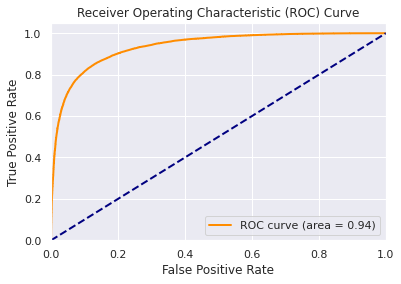

1529/1529 [==============================] - 5s 3ms/step - loss: 0.3280 - acc: 0.8601

테스트 정확도: 0.8601
ROC AUC: 0.9354


In [249]:
path = 'best_lstm_model_sentencepiece_bpe.h5'
get_roc_curve(path, X_test, y_test)

# 최종 성능 비교 및 결론

## Sentence Piece 결과 정리 (test acc 기준)
- lstm model : 0.8601
- stacked lstm model : 0.8517
- 1d cnn model : 0.8557

## 최종 형태소별 성능 정리 ( lstm model )

- hannanum : 0.8199 (빈 샘플 수 : 5513)
- komoran : 0.8544 (빈 샘플 수 : 2278)
- mecab : 0.8649 (빈 샘플 수 : 202)
- okt
    - stem = False : 0.8586 (빈 샘플 수 : 395)
    - stem = True : 0.8613 (빈 샘플 수 : 241)


- 빈 샘플 수에 비례해 성능이 좋아지는 것을 볼 수 있다
- 이에 따라 성능 향상에 토큰을 잘 나누는 것이 매우 중요한 요소로 보인다

## SentencePiece vocab size, model type 변화
- vocab_size = 21741로 늘림 : 0.8608
- model type = bpe로 변경 : 0.8601

    - 성능 향상에 큰 변화가 없었다

# 회고
- 배운 점 
    - 언젠가 한번 쯤은 형태소 분석기별로 성능을 비교해보고 싶었는데 이번 기회로 제대로 비교할 수 있었던 좋은 기회였다
    - 좀 더 task specific하게 전처리를 진행해볼 수 있어 좋은 기회였다
- 아쉬운 점 
    - 좀 더 체계적으로 비교를 해보고 싶었는데 시간상의 이유로 제대로 비교해보지 못해서 아쉽다
- 느낀 점
    - task 별로 성능이 좋은 모델, 토큰화 방식이 다를 수 있다.
- 어려웠던 점 
    - 코드를 좀 더 재사용성있게 짜는 방법을 더 고민해봐야겠다